## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels'),
 PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt')]

In [18]:
import pandas as pd
df = pd.read_csv(path/'valid.txt')
df

,0016E5_07959.png
0,0016E5_07961.png
1,0016E5_07963.png
2,0016E5_07965.png
3,0016E5_07967.png
4,0016E5_07969.png
5,0016E5_07971.png
6,0016E5_07973.png
7,0016E5_07975.png
8,0016E5_07977.png
9,0016E5_07979.png


In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [ ]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/0006R0_f01020.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_06390.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/Seq05VD_f01830.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0006R0_f02340_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_01230_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_009150_P.png')]

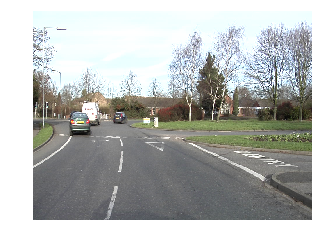

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
img_f.stem, img_f.suffix

('0006R0_f01020', '.png')

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}' # deduce label path from img path

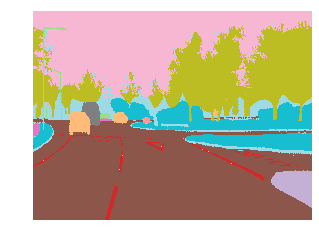

In [10]:
mask = open_mask(get_y_fn(img_f)) # function to show image according to a mask matrix
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:]) # mask.shape => (1,720,960) only 1 input layer
src_size,mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes # the order corresponds to the labels, i.e. label 4 = Building

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [13]:
size = src_size//2 # start with 1/4 of the photo size for training

free = gpu_mem_get_free_no_cache() # returns free memory of machine
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7601MB of GPU RAM free


In [14]:
src = (SegmentationItemList.from_folder(path_img) # SegmentationItemList, special class for segmentation classification
       .split_by_fname_file('../valid.txt') # since photos are captured from videos, many photos may involve a similar scene, so the valid data should be scenes that a completely different from the training data, therefore the valid data is specifically defined (by valid.txt)
       .label_from_func(get_y_fn, classes=codes))

In [15]:
data = (src.transform(get_transforms(), size=size, tfm_y=True) # tfm_y = True applies transformations to the mask(y/label) as well, so it matches to the scene(X)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

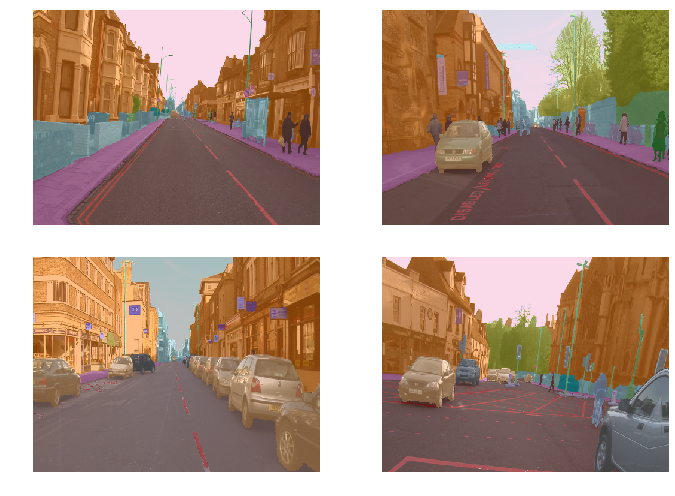

In [16]:
data.show_batch(2, figsize=(10,7))

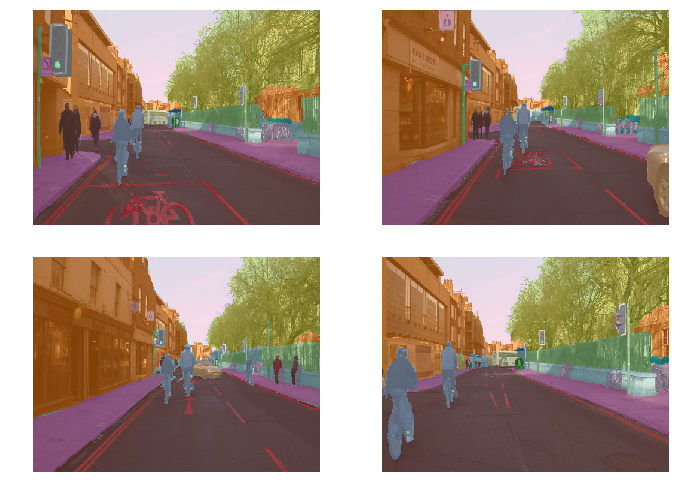

In [23]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [21]:
# data required parsing for obtaining the accuracy, as some pixels in the mask(s) is marked 'Void', which should not count towards to accuracy
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean() # label with highest prob == actual label for labels that are not 'Void'

In [22]:
metrics=acc_camvid
# metrics=accuracy

In [23]:
wd=1e-2

In [24]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd) # unet is a better model for segmentation task; wd: 'weight decay' (for explanation on wd, see: https://metacademy.org/graphs/concepts/weight_decay_neural_networks)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


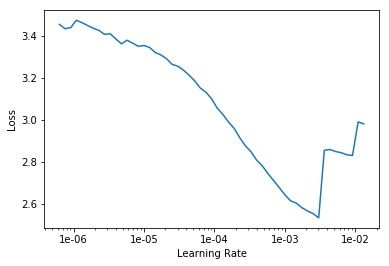

In [28]:
lr_find(learn)
learn.recorder.plot()

In [30]:
lr=3e-3

In [30]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.954445,0.709005,0.834642,01:48
1,0.740814,0.685473,0.829373,01:48
2,0.690083,0.742683,0.818409,01:49
3,0.627845,0.686017,0.838838,01:48
4,0.596411,0.488317,0.864669,01:49
5,0.602324,0.501342,0.871028,01:48
6,0.600881,0.525089,0.860207,01:47
7,0.527859,0.394829,0.889108,01:47
8,0.524720,0.392343,0.889514,01:46
9,0.420714,0.329497,0.903084,01:46


In [31]:
learn.save('stage-1')

In [25]:
learn.load('stage-1');

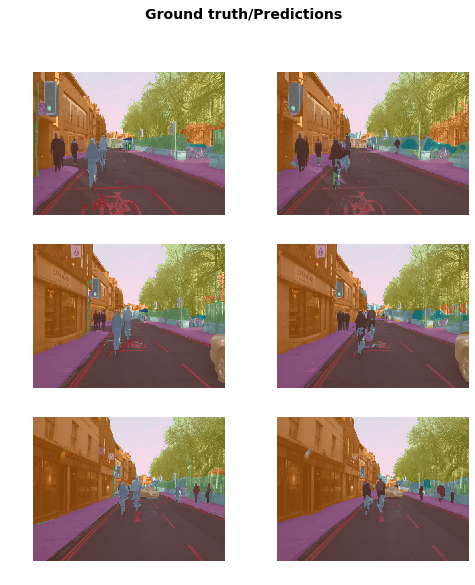

In [26]:
learn.show_results(rows=3, figsize=(8,9))

In [27]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


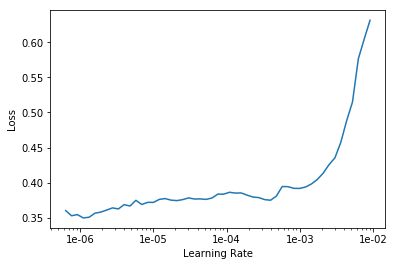

In [28]:
lr_find(learn)
learn.recorder.plot()

In [31]:
lrs = slice(lr/400,lr/4)
lrs

slice(7.5e-06, 0.00075, None)

In [32]:
learn.fit_one_cycle(12, lrs, pct_start=0.8) # pct_start: within an epock, 80% of the iters have lr rise, the remaining 20% have lr decrease

epoch,train_loss,valid_loss,acc_camvid,time
0,0.374513,0.316162,0.907670,01:48
1,0.367044,0.317859,0.906108,01:47
2,0.357348,0.310564,0.907421,01:49
3,0.351816,0.302728,0.911735,01:49
4,0.351493,0.292915,0.917718,01:49
5,0.333480,0.301517,0.912685,01:49
6,0.327773,0.278639,0.921984,01:49
7,0.325572,0.319845,0.907685,01:49
8,0.324288,0.300667,0.916572,01:49
9,0.317275,0.268984,0.925932,01:49


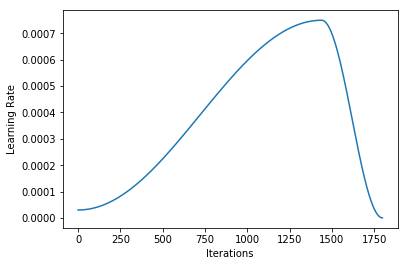

In [33]:
learn.recorder.plot_lr() # graphical representation of pct_start set to 0.8

In [34]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [48]:
#learn.destroy() # uncomment once 1.0.46 is out

size = src_size # use total size of photo after training the model on a smaller version

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=1, have 6316MB of GPU RAM free


In [37]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [38]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [39]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


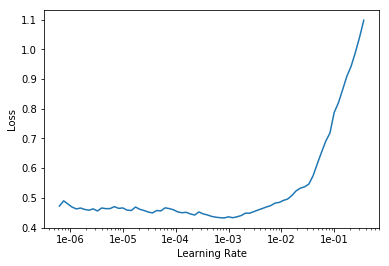

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [40]:
lr=1e-3

In [41]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.439539,0.341379,0.908817,07:14
1,0.374266,0.344960,0.907218,07:09
2,0.347244,0.289114,0.919027,07:09
3,0.353433,0.285693,0.923041,07:09
4,0.343180,0.290971,0.917576,07:09
5,0.354917,0.313309,0.912621,07:09
6,0.332210,0.344676,0.904245,07:09
7,0.355443,0.305092,0.923463,07:08
8,0.290826,0.295059,0.926927,07:08
9,0.231669,0.278495,0.929320,07:08


In [42]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.225999,0.254650,0.930782
2,0.216341,0.256007,0.930751
3,0.209800,0.255649,0.930709
4,0.203509,0.252857,0.931682
5,0.202308,0.258498,0.931308
6,0.200796,0.257311,0.931915
7,0.204560,0.251486,0.933218
8,0.192893,0.254977,0.932786
9,0.189505,0.258091,0.932555
10,0.190156,0.256064,0.933315


In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

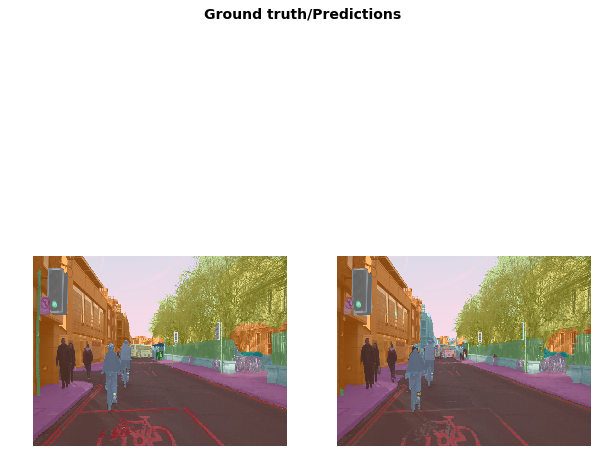

In [47]:
learn.show_results(rows=3, figsize=(10,10))

## fin